# Project Milestone 2

## Tools

In [ ]:
pip install pandas==1.0.5

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import nltk
import requests
import pickle
import warnings
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
print('pandas version: ' + pd.__version__)

pandas version: 1.0.5


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_data = '/content/drive/MyDrive/Quotebank/'

In [5]:
# loop through nb_chunks_to_read chunks (if 0, through all chunks) and apply process_function to each of them
# return the result as a dataframe
def loop_chuncks(chunks, process_function, nb_chunks_to_read=0):
  i = 0
  result = []
  columns = None
  for chunk in chunks:
    processed = process_function(chunk)
    if processed is not None:
      if not isinstance(processed, pd.Series):
        columns = processed.columns
      for r in processed.values.tolist():
        result.append(r)
    i += 1
    if i == nb_chunks_to_read:
      break
  return pd.DataFrame(result, columns=columns)

In [6]:
# return the first 3 elements of a chunk
def chunck_head(chunk):
  return chunk.head(3)

# example
chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
loop_chuncks(chunks, chunck_head, 1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E


In [7]:
# to create automatically a list of synonyms
# https://towardsdatascience.com/synonyms-and-antonyms-in-python-a865a5e14ce8
nltk.download('wordnet')

def find_synonyms(word):
  words = []
  for syn in wordnet.synsets(word):
    for lm in syn.lemmas():
      words.append(lm.name())
  return words

# example
find_synonyms('climate')
find_synonyms('environment')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


['environment', 'environment', 'environs', 'surroundings', 'surround']

## Creation of the dataset about climate change

In [8]:
# return the quotes containing one of the words in the list

words = ['global warming', 'climate change']

def contains_word_in_list(chunk):
  return chunk[chunk.quotation.str.contains('|'.join(words))]

chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
word_in_list_quotes = loop_chuncks(chunks, contains_word_in_list, 3)

word_in_list_quotes.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
39,2020-03-16-027132,"If storminess increases with climate change, a...",None,[],2020-03-16 00:00:00,3,"[[None, 0.9405], [Andrew Ashton, 0.0595]]",[http://news.mit.edu/2020/wave-power-coastal-e...,E
25,2020-02-06-075836,press companies to disclose plans for operatin...,Larry Fink,"[Q3218882, Q6490307]",2020-02-06 05:00:00,1,"[[Larry Fink, 0.8982], [None, 0.1018]]",[http://businesslive.co.za/fm/money-and-invest...,E
0,2020-02-27-004325,And it's also in the context of decades of utt...,None,[],2020-02-27 15:17:36,1,"[[None, 0.8786], [Bernie Sanders, 0.1214]]",[http://www.eenews.net/stories/1062457547],E


In [9]:
# to load and save pickes (from the course tutorial)
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

In [10]:
# create a pickle of the quotes about climate change for the 2020 dataset
# this have been done for the 6 datasets, commented to not re-run it (very long)
# chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
# climate_2020 = loop_chuncks(chunks, contains_word_in_list)
# path_pickle_2020 = '/content/drive/MyDrive/pickle_2020'
# save_pickle(word_in_list_quotes, path_pickle_2020)

In [11]:
# load the pickles
# the pickles need to be added to the drive
# download here: https://drive.google.com/drive/folders/1j1Bp1niC0_cqg1kN_LbSrA2TGnq5MTgt?usp=sharing
climate_2015 = load_pickle('/content/drive/MyDrive/pickle_2015')
climate_2016 = load_pickle('/content/drive/MyDrive/pickle_2016')
climate_2017 = load_pickle('/content/drive/MyDrive/pickle_2017')
climate_2018 = load_pickle('/content/drive/MyDrive/pickle_2018')
climate_2019 = load_pickle('/content/drive/MyDrive/pickle_2019')
climate_2020 = load_pickle('/content/drive/MyDrive/pickle_2020')
all_years_list = [climate_2015, climate_2016, climate_2017, climate_2018, climate_2019, climate_2020]
all_years = [2015, 2016, 2017, 2018, 2019, 2020]
for i in range(len(all_years)):
  all_years_list[i]['year'] = all_years[i]

In [12]:
# create one dataframe for all the years
climate_all_years = pd.concat(all_years_list, ignore_index=True)
print(climate_all_years.shape)
climate_all_years.sample(3)

(141512, 10)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year
114336,2019-12-06-089684,The reality of climate change-hotter and drier...,Malcolm Turnbull,[Q927550],2019-12-06 16:09:13,1,"[[Malcolm Turnbull, 0.8551], [None, 0.1449]]",[http://cnn.com/2019/12/06/australia/sydney-sm...,E,2019
3828,2015-07-17-024982,He leaves a legacy of helping people learn abo...,John Houck,[Q16193645],2015-07-17 03:39:03,6,"[[John Houck, 0.8857], [None, 0.1073], [Karen ...",[http://www.kirotv.com/news/news/point-defianc...,E,2015
141487,2020-01-24-105942,We'll see weather bombs in the future -- very ...,None,[],2020-01-24 01:50:24,6,"[[None, 0.8002], [Christian Seiler, 0.1998]]",[http://www.gfwadvertiser.ca/news/canada/frida...,E,2020


## First analyses

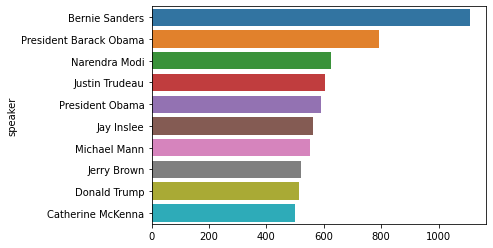

In [13]:
# the top speakers talking about climate change
top_speakers = climate_all_years.groupby(by='speaker').count().sort_values(by='quotation', ascending=False).quotation.iloc[1:21]
sns.barplot(x=top_speakers[:10].values, y=top_speakers[0:10].index)

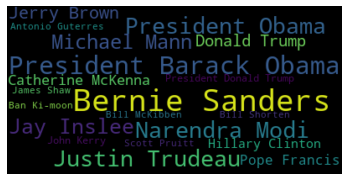

In [14]:
# word cloud of top speakers for illustration
wordcloud = WordCloud().fit_words(dict(top_speakers))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


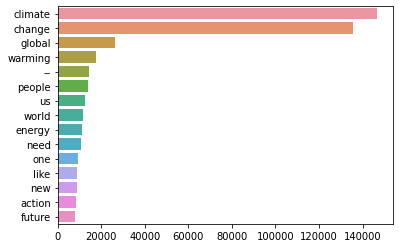

In [15]:
# words being most used in these quotes about global warming
nltk.download('stopwords')
topic_words = collections.Counter()
stop_words = set(stopwords.words('english'))
for index, row in climate_all_years.iterrows():
    for word in row.quotation.lower().replace(',', '').replace('.', '').split():
        if word not in stop_words:
            topic_words[word] += 1
top_50_climate_words = topic_words.most_common()[:50]
sns.barplot(x=[x[1] for x in top_50_climate_words][:15], y=[x[0] for x in top_50_climate_words][:15])

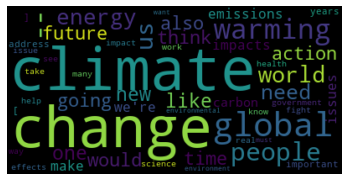

In [16]:
# word cloud for illustration
wordcloud = WordCloud().fit_words(dict(top_50_climate_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Quotations about global warming though time')

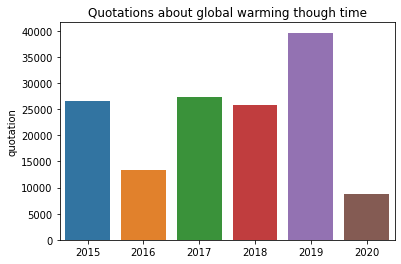

In [17]:
# number of quotations about global warming through the years
count_years =  climate_all_years.groupby(by='year').count().quotation
sns.barplot(x=all_years, y=count_years)
plt.title("Quotations about global warming though time")

## Tools for wikidata

In [18]:
# read the wikidata file
path_data_wikidata = '/content/drive/MyDrive/speaker_attributes.parquet/'
wikidata = pd.read_parquet(path_data_wikidata)
wikidata.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None


In [19]:
# to find the label of a QID
# from https://stackoverflow.com/questions/40268148/how-to-get-wikidata-labels-by-id-using-sparql

def find_QID_label(QID):
  url = 'https://query.wikidata.org/sparql'
  query = '''
  PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
  PREFIX wd: <http://www.wikidata.org/entity/> 
  SELECT  *
  WHERE {
          wd:%s rdfs:label ?label .
          FILTER (langMatches( lang(?label), "EN" ) )
        } 
  LIMIT 1
  ''' % (QID)
  result = requests.get(url, params = {'format': 'json', 'query': query})
  return result.json().get('results').get('bindings')[0].get('label').get('value')

# example
find_QID_label('Q161885')

'Great Britain'

In [20]:
# wikidata dataframe without the None name
wikidata_clean = wikidata.dropna(axis=0, subset=['aliases'])

In [21]:
# to find a speaker in the wikidata df
def find_speaker(speaker):
  return wikidata_clean[wikidata_clean.aliases.apply(lambda x: speaker in x[0])]

# example
find_speaker('Joseph Biden')

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
4529264,"[Joseph Biden, Joseph R. Biden, Joseph R. Bide...",[+1942-11-20T00:00:00Z],[Q30],[Q6581097],1395965219,None,B000444,"[Q82955, Q40348, Q1622272]",[Q29552],"[Q1540185, Q1765120]",Q6279,Joe Biden,"[Q22923830, Q7891450]",item,[Q1841]
7147986,"[Joseph Biden Sr., Joseph Robinette Biden Sr.]",[+1915-11-13T00:00:00Z],[Q30],[Q6581097],1393419215,None,None,None,None,None,Q20177093,Joseph R. Biden Sr.,None,item,None


## Nationalities

In [22]:
#To use if we want only the first nationality of the speaker
#Create a dataframe for the parquet information of the speakers
df = wikidata

#We will use only the 'nationality', 'id' and 'label' data from this dataframe
df = df[['nationality', 'label', 'id']]

#We are changing the 'None' value to an empty array
empty = pd.Series([[] for _ in range(len(df.index))], index=df.index)
df['nationality'] = df['nationality'].fillna(empty)

#Here, we are extracting the first nationality of every speaker, and changing the qid country code to -999
#for every speaker that did not have a specified nationality
df['nationality'] = df.nationality.apply(lambda x: x[0] if len(x) > 0 else 'Q-999')

df['nationality'].value_counts().head(20)

Q-999     5340129
Q30        430536
Q142       261891
Q183       249957
Q17        177541
Q145       162521
Q29        125935
Q9903      125906
Q38         95147
Q16         81559
Q34         78606
Q15180      76904
Q36         72444
Q29999      71745
Q155        69840
Q8733       65530
Q668        58211
Q20         55953
Q31         51919
Q408        51617
Name: nationality, dtype: int64

In [23]:
# drop the rows with speaker None
climate_all_years_clean = climate_all_years.drop(climate_all_years.index[climate_all_years['speaker'] == 'None'])
climate_all_years_clean.shape

(98166, 10)

In [24]:
# load the QID dataset
qids = pd.read_csv('/content/drive/MyDrive/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
qids.head(2)

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe


In [25]:
# merge the quotes about global warming with the countries from wikidata using the qids
climate_countries = climate_all_years_clean.explode('qids').merge(wikidata, left_on='qids', right_on='id')
print(climate_countries.shape)
climate_countries.head(3)

(201888, 25)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,2015-09-28-067347,man-made emissions are an insignificant part o...,John Abraham,Q313025,2015-09-28 23:16:52,1,"[[John Abraham, 0.6469], [None, 0.3092], [Will...",[http://www.desmogblog.com/donors-capital-fund],E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,Q313025,John Abraham,None,item,[Q5043]
1,2015-09-17-007663,Any argument that global warming stopped 18 or...,John Abraham,Q313025,2015-09-17 10:01:00,2,"[[John Abraham, 0.8673], [None, 0.1292], [Lama...",[http://www.environmentalhealthnews.org/t/1883...,E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,Q313025,John Abraham,None,item,[Q5043]
2,2015-08-06-023574,found that there was no statistically signific...,John Abraham,Q313025,2015-08-06 15:00:59,1,"[[John Abraham, 0.7957], [None, 0.1579], [Greg...",[http://dailykos.com/story/2015/08/06/1409298/...,E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,Q313025,John Abraham,None,item,[Q5043]


In [26]:
# add the labels of the countries
climate_countries_label = climate_countries.explode('nationality').merge(qids, left_on='nationality', right_on='QID')
print(climate_countries_label.shape)
climate_countries_label.drop(columns=['id', 'label', 'Description', 'aliases', 'date_of_birth', 'gender', 
                                      'lastrevid', 'ethnic_group', 'US_congress_bio_ID', 'occupation',
                                      'party', 'academic_degree', 'candidacy', 'type', 'religion'], axis=1, inplace=True)
climate_countries_label = climate_countries_label.rename(columns={'nationality': 'nationality_qid', 
                                                                  'Label': 'nationality_label'})
climate_countries_label.sample(3)

(162917, 27)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,nationality_qid,nationality_label
123793,2019-10-07-084135,They should not be making recommendations on t...,David Jenkins,Q932705,2019-10-07 18:17:34,1,"[[David Jenkins, 0.8346], [None, 0.1654]]",[https://leaderpost.com/health/eating-red-meat...,E,2019,Q145,United Kingdom
34015,2019-09-17-106272,We have ten years to radically transform our c...,Mike O'Brien,Q16215980,2019-09-17 04:00:00,1,"[[Mike O'Brien, 0.8046], [None, 0.1954]]",[https://www.commondreams.org/news/2019/09/17/...,E,2019,Q30,United States of America
89987,2017-10-10-129755,There's a good argument for decoupling climate...,Grant King,Q5596295,2017-10-10 02:06:13,1,"[[Grant King, 0.7992], [None, 0.2008]]",[http://www.afr.com/business/energy/electricit...,E,2017,Q408,Australia


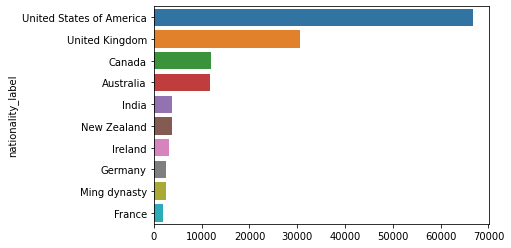

In [27]:
# number of quotes by countries
countries = climate_countries_label.groupby(by='nationality_label').count().sort_values(by='quotation', ascending=False).quotation
sns.barplot(x=countries[:10].values, y=countries[:10].index)

In [28]:
pip install pycountry

     |████████████████████████████████| 10.1 MB 13.8 MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=c7909afc638f0c2899d71cf46528f85aa59ec882c5d7e7e4a77cf4a8f50b9157
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


In [29]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 13.2 MB/s 
     |████████████████████████████████| 15.4 MB 81 kB/s 
     |████████████████████████████████| 6.3 MB 53.3 MB/s 


In [30]:
pip install mapclassify

In [31]:
import pycountry 
import geopandas

In [32]:
# generate country code  based on country name 
# from https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

In [33]:
# add to the country dataframe all the infos about the countries for the world map
countries_df = pd.DataFrame(countries)
countries_df.reset_index(inplace=True)
countries_df.replace('United States of America', 'United States', inplace=True)
countries_df['CODE'] = alpha3code(countries_df.nationality_label)
countries_df = countries_df.drop(countries_df.index[countries_df['CODE'] == 'None'])
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
countries_geo = pd.merge(world, countries_df,on='CODE')
countries_geo.sample(3)

,pop_est,continent,name,CODE,gdp_md_est,geometry,nationality_label,quotation
39,3758571,Africa,Mauritania,MRT,16710.0,"POLYGON ((-17.06342 20.99975, -16.84519 21.333...",Mauritania,1
77,9960487,Europe,Sweden,SWE,498100.0,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...",Sweden,626
62,2875422,Asia,Kuwait,KWT,301100.0,"POLYGON ((47.97452 29.97582, 48.18319 29.53448...",Kuwait,4


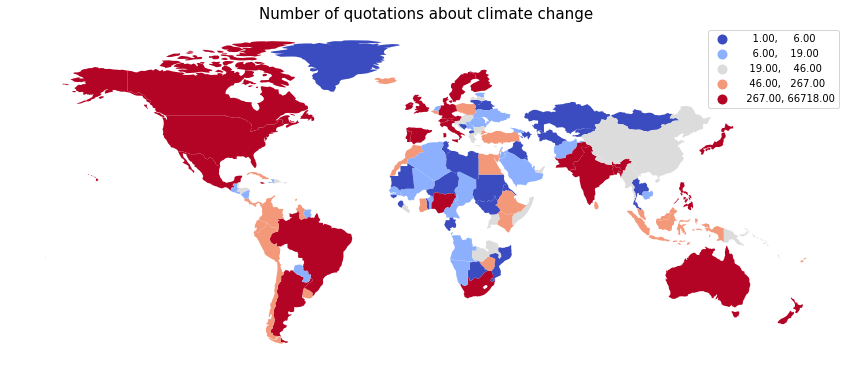

In [34]:
# plot the number of quotations on the world map
countries_geo.plot(column='quotation', scheme="quantiles", figsize=(15, 20), legend=True, cmap='coolwarm')
plt.title('Number of quotations about climate change',fontsize=15)
plt.axis("off")
plt.show()

## Data about climate change from wordbank

https://data.worldbank.org/topic/19

In [35]:
# for later use ?
path_data_wordbank1 = '/content/drive/MyDrive/worlddatabank/Metadata_Country_API_19_DS2_en_csv_v2_3159902.csv'
wordbank_meta_Country = pd.read_csv(path_data_wordbank1)
wordbank_meta_Country.head(3)

path_data_wordbank2 = '/content/drive/MyDrive/worlddatabank/Metadata_Indicator_API_19_DS2_en_csv_v2_3159902.csv'
wordbank_meta_Indicator = pd.read_csv(path_data_wordbank2)
wordbank_meta_Indicator.head(3)


,INDICATOR_CODE,INDICATOR_NAME,SOURCE_NOTE,SOURCE_ORGANIZATION,Unnamed: 4
0,SP.URB.TOTL.IN.ZS,Urban population (% of total population),Urban population refers to people living in ur...,United Nations Population Division. World Urba...,NaN
1,SP.URB.TOTL,Urban population,Urban population refers to people living in ur...,World Bank staff estimates based on the United...,NaN
2,SP.URB.GROW,Urban population growth (annual %),Urban population refers to people living in ur...,World Bank staff estimates based on the United...,NaN


## Political parties

In [36]:
# merge the quotes about global warming with the wikidata using the qids
climate_wikidata = climate_all_years_clean.explode('qids').merge(wikidata, left_on='qids', right_on='id')
climate_wikidata.drop(columns=['id', 'label'], axis=1, inplace=True)
print(climate_wikidata.shape)
climate_wikidata.head(3)

(201888, 23)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,candidacy,type,religion
0,2015-09-28-067347,man-made emissions are an insignificant part o...,John Abraham,Q313025,2015-09-28 23:16:52,1,"[[John Abraham, 0.6469], [None, 0.3092], [Will...",[http://www.desmogblog.com/donors-capital-fund],E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,None,item,[Q5043]
1,2015-09-17-007663,Any argument that global warming stopped 18 or...,John Abraham,Q313025,2015-09-17 10:01:00,2,"[[John Abraham, 0.8673], [None, 0.1292], [Lama...",[http://www.environmentalhealthnews.org/t/1883...,E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,None,item,[Q5043]
2,2015-08-06-023574,found that there was no statistically signific...,John Abraham,Q313025,2015-08-06 15:00:59,1,"[[John Abraham, 0.7957], [None, 0.1579], [Greg...",[http://dailykos.com/story/2015/08/06/1409298/...,E,2015,None,[+1972-12-17T00:00:00Z],[Q668],[Q6581097],1354134367,None,None,"[Q33999, Q4610556, Q3282637, Q10800557]",None,None,None,item,[Q5043]


In [37]:
# add the labels of the parties
climate_wikidata_label = climate_wikidata.explode('party').merge(qids, left_on='party', right_on='QID')
climate_wikidata_label.drop(columns=['Description'], axis=1, inplace=True)
climate_wikidata_label.rename(columns={'Label': 'party_label'}, inplace=True)

In [38]:
# add the labels of all the countries
climate_wikidata_label = climate_wikidata_label.explode('nationality').merge(qids, left_on='nationality', right_on='QID')
climate_wikidata_label.drop(columns=['Description'], axis=1, inplace=True)
climate_wikidata_label.rename(columns={'Label': 'nationality_label'}, inplace=True)
climate_wikidata_label.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,candidacy,type,religion,party_label,nationality_label
30374,2019-08-07-104377,We laugh at the superstition and folly of thos...,Tom McClintock,Q535887,2019-08-07 05:54:06,1,"[[Tom McClintock, 0.6977], [None, 0.2933], [Pr...",[https://www.heartland.org/news-opinion/news/c...,E,2019,None,[+1956-07-10T00:00:00Z],Q30,[Q6581097],1393631560,None,M001177,"[Q82955, Q1930187, Q485178]",Q29468,None,None,item,None,Republican Party,United States of America
14757,2019-04-18-059147,We must achieve 100 percent clean and renewabl...,Kirsten Gillibrand,Q22222,2019-04-18 09:00:12,1,"[[Kirsten Gillibrand, 0.5546], [Tulsi Gabbard,...",[https://www.nytimes.com/2019/04/18/us/politic...,E,2019,"[Kirsten Elizabeth Rutnik Gillibrand, Kirsten ...",[+1966-12-09T00:00:00Z],Q30,[Q6581072],1392787827,None,G000555,"[Q82955, Q40348]",Q29552,"[Q1765120, Q1540185, Q18745564]",None,item,"[Q9592, Q7361618]",Democratic Party,United States of America
21235,2020-02-21-040580,join a cohort of leading companies that take a...,Michael Bloomberg,Q607,2020-02-21 17:06:43,1,"[[Michael Bloomberg, 0.7205], [None, 0.2795]]",[https://www.manilatimes.net/2020/02/22/busine...,E,2020,"[Michael Rubens Bloomberg, Michael R. Bloomber...",[+1942-02-14T00:00:00Z],Q30,[Q6581097],1391164280,[Q7325],None,"[Q43845, Q82955, Q2095549, Q36180, Q1424605, Q...",Q29468,None,None,item,"[Q9268, Q1133485]",Republican Party,United States of America


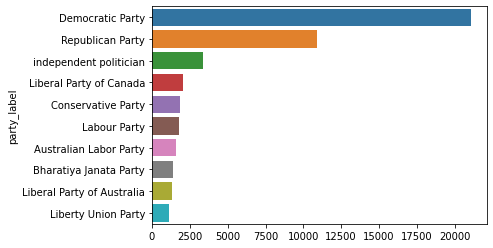

In [39]:
# number of quotes by parties in the world
parties = climate_wikidata_label.groupby(by='party_label').count().sort_values(by='quotation', ascending=False).quotation
sns.barplot(x=parties[:10].values, y=parties[:10].index)

In [40]:
# number of quotes by countries and parties in the world
parties_countries = climate_wikidata_label.groupby(by=['nationality_label', 'party_label']).count().sort_values(by='quotation', ascending=False).quotation
parties_countries_df = pd.DataFrame(parties_countries)
parties_countries_df.reset_index(inplace=True)
parties_countries_df = pd.DataFrame(parties_countries)
parties_countries_df.reset_index(inplace=True)

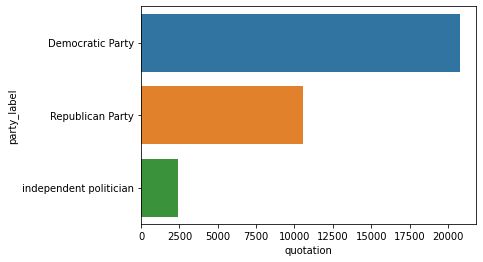

In [41]:
# parties for the USA
US_data = parties_countries_df[parties_countries_df.nationality_label == 'United States of America']
sns.barplot(data=US_data[:3], x='quotation', y='party_label')

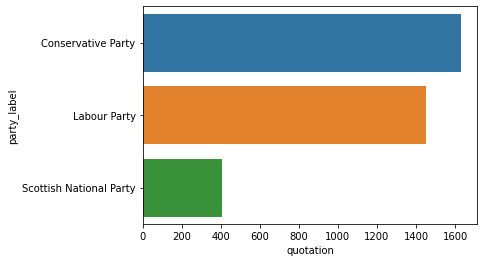

In [42]:
# parties for the UK
UK_data = parties_countries_df[parties_countries_df.nationality_label == 'United Kingdom']
sns.barplot(data=UK_data[:3], x='quotation', y='party_label')

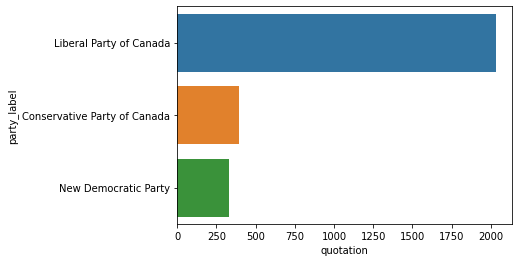

In [43]:
# parties for Canada
canada_data = parties_countries_df[parties_countries_df.nationality_label == 'Canada']
sns.barplot(data=canada_data[:3], x='quotation', y='party_label')

## Age categories

In [44]:
# to find the age category
def age_category(age):
  if age < 17:
    return '0-16'
  elif age < 31:
    return '17-30'
  elif age < 46:
    return '31-45'
  elif age < 66:
    return '46-65'
  else:
    return '66+'

In [45]:
# create birth_year, age and age_category columns
climate_wikidata_ages = climate_wikidata_label.dropna(axis=0, subset=['date_of_birth'])
climate_wikidata_ages['birth_year'] = climate_wikidata_ages.date_of_birth.apply(lambda x: int(x[0][1:5]))
climate_wikidata_ages['age'] = climate_wikidata_ages['year'] - climate_wikidata_ages['birth_year']
climate_wikidata_ages['age_category'] = climate_wikidata_ages['age'].apply(age_category)
climate_wikidata_ages.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,candidacy,type,religion,party_label,nationality_label,birth_year,age,age_category
15831,2019-05-18-031145,Let's stop fighting and start fixing. And we c...,Jill Biden,Q235349,2019-05-18 21:15:27,8,"[[Jill Biden, 0.6432], [None, 0.3443], [Presid...",[http://6abc.com/joe-biden-gives-pitch-on-unit...,E,2019,"[Jill Tracy Jacobs Biden, Jill Tracy Biden, Ji...",[+1951-06-03T00:00:00Z],Q30,[Q6581072],1392844379,None,None,"[Q203184, Q82955, Q37226]",Q29552,None,None,item,None,Democratic Party,United States of America,1951,68,66+
69001,2019-02-13-099821,We know that 30 percent of the land area of th...,Winston Lackin,Q3486213,2019-02-13 18:03:05,2,"[[Winston Lackin, 0.9267], [None, 0.0733]]",[http://www.globalissues.org/news/2019/02/13/2...,E,2019,None,[+1954-12-23T00:00:00Z],Q730,[Q6581097],1332660270,None,None,[Q82955],Q2420320,None,None,item,None,National Democratic Party,Suriname,1954,65,46-65
30179,2017-06-02-009735,As someone who believes that climate change is...,Brian Mast,Q27733854,2017-06-02 14:08:02,1,"[[Brian Mast, 0.9243], [None, 0.0713], [Don Ba...",[http://www.climatechangenews.com/2017/06/02/r...,E,2017,[Brian J. Mast],[+1980-07-10T00:00:00Z],Q30,[Q6581097],1392217146,None,M001199,"[Q82955, Q485178]",Q29468,None,None,item,None,Republican Party,United States of America,1980,37,31-45


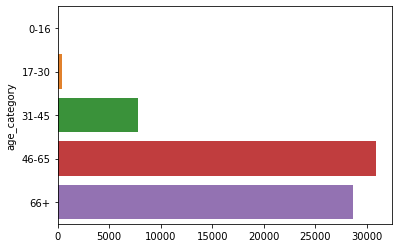

In [46]:
# number of quotes by age category in the world
age_categories = climate_wikidata_ages.groupby(by='age_category').count().quotation
sns.barplot(x=age_categories[:10].values, y=age_categories[:10].index)